## Brillouin-Wigner correction of the quasiparticle Hamiltonian

We approach and analyze the structure of the corrections and the properties of these effective Hamiltonians using both the nn-pp quasiparticle and the nn-pp/ np quasiparticle frameworks.

### Get $H_Q$, $H_{RQ}$, $H_{QR}$ and $H_{RR}$ in the nn-pp framework

#### Imports

In [1]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverterOnlynnpp


/home/ecosta/miniconda3/envs/annealing-nsm-env/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


#### Hyperparameters of the system, select the nucleus

Set the Interaction and the subshells

In [ ]:
file_name='data/usdb.nat' #select the file with the single particle energies and two-body matrix elements
# initialize the class that handles single particle states
# load the twobody matrix as a dictionary
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



  8%|▊         | 2/24 [00:06<01:10,  3.21s/it]

Set the specific nucleus

In [ ]:

SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a=4
nparticles_b=2
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2
# name of the nucleus
title=r'$^{22}$Ne'



Compute the NSM Hamiltonian

In [334]:
# initialize the nuclear shell model hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
NSMHamiltonian.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
NSMHamiltonian.get_hamiltonian()
# compute eigenvectors and eigenvalues in the active configuration interaction
eigvals_aci,eigvecs_aci=NSMHamiltonian.get_spectrum(n_states=1)

print(eigvals_aci)

print(NSMHamiltonian.hamiltonian.shape)

Building two-body operator with 16496 terms...


100%|██████████| 16496/16496 [00:00<00:00, 19894.03it/s]

✅ Two-body operator built: shape=(640, 640), nnz=54120
[-94.26427432]
(640, 640)


#### Get the Quasiparticle basis and compute the operators

In [335]:
# Initialize the quasiparticle class
QPC=QuasiParticlesConverterOnlynnpp()
# intialize the quasiparticle modes
QPC.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
# check the basis reduction
print(QPC.quasiparticle_basis.shape)
print(QPC.rest_basis.shape)



(36, 12)
(604, 24)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [336]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


#### Create a probability distribution over the diagonal values of $H_{RR}$

Since we want to reconstruct randomly the mean field component of $H_{RR}$ that contributes to the magnitude of each virtual process in the two-body truncation. We sample the values using the distribution generated by the mean field Hamiltonian. For large system size this can be esily performed using a Monte Carlo algorithm, like Metropolis Hasting.

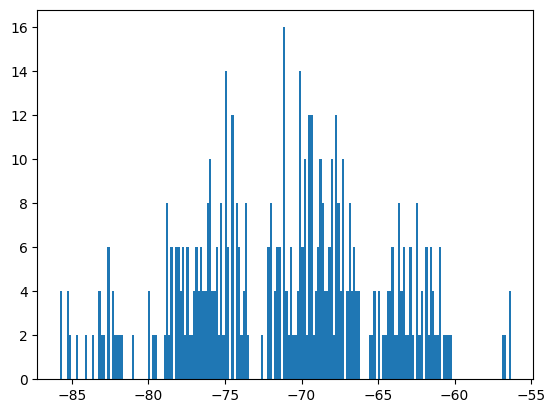

[ 4  0  0  4  2  0  0  2  0  0  0  2  0  0  2  0  0  4  2  2  0  6  0  4
  2  2  2  2  0  0  0  0  2  0  0  0  0  0  0  4  0  2  2  0  0  0  2  8
  2  6  0  6  6  4  6  2  6  2  2  4  6  4  6  4  4  8 10  4  4  6  2  8
  2 14  6  0 12  0  8  6  2  4  8  2  0  0  0  0  0  2  0  0  6  8  0  4
  6  6  0 16  4  2  6  2  2  4 14  6 10  2 12 12  2  4  6 10  8  4  4  6
 10  2 12  8  4 10  0  4  8  4  6  4  4  0  0  0  0  2  2  4  0  4  0  2
  2  4  4  6  2  2  8  4  6  2  2  6  2  0  8  2  4  0  6  2  6  4  2  2
  6  0  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  2  2  0  4]
[-85.77674702 -85.62947087 -85.48219471 -85.33491855 -85.1876424
 -85.04036624 -84.89309008 -84.74581393 -84.59853777 -84.45126161
 -84.30398546 -84.1567093  -84.00943315 -83.86215699 -83.71488083
 -83.56760468 -83.42032852 -83.27305236 -83.12577621 -82.97850005
 -82.83122389 -82.68394774 -82.53667158 -82.38939542 -82.24211927
 -82.09484311 -81.94756695 -81.8002908  -81.65301464 -81.5057

In [337]:
bins=200
_=plt.hist(hamiltonian_rr.diagonal(),bins=bins)
plt.show()

hist_diag_hamiltonian_rr,range_energies_rr=np.histogram(hamiltonian_rr.diagonal(),bins=bins)
print(hist_diag_hamiltonian_rr)
print(range_energies_rr)
probability_distribution_diag_hamiltonian_rr=hist_diag_hamiltonian_rr/np.sum(hist_diag_hamiltonian_rr)

#### Investigate the magnitude of $H_{QR}$

In [338]:
for q_index in range(2):
    for r_index in range(hamiltonian_qr.shape[1]):
        if hamiltonian_qr[q_index,r_index]!=0:
            print('q_index=',q_index,' r_index=',r_index,' value=',hamiltonian_qr[q_index,r_index])
            idx_q=np.nonzero(QPC.quasiparticle_basis[q_index])[0]
            indices=[]
            quasiparticle_element_in_full_basis=np.zeros_like(QPC.rest_basis[r_index])
            for qi0 in idx_q:
                indices.append(QPC.couples[qi0][0])
                indices.append(QPC.couples[qi0][1])
            print(indices)
            quasiparticle_element_in_full_basis[indices]=1
            print(np.sum(np.abs(quasiparticle_element_in_full_basis-QPC.rest_basis[r_index])))
            print('\n')

q_index= 0  r_index= 0  value= -0.30779692951934234
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 5  value= 0.5106312858160081
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 6  value= 0.21613933262539425
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 9  value= 0.5755836505313379
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 16  value= 0.062155239113214744
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 20  value= 0.20328479938540367
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 21  value= -0.5082840208321852
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 22  value= 0.1894946496437248
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 23  value= 0.5082840208321852
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 24  value= 0.18949464964372487
[0, 5, 1, 4, 2, 3, 6, 7, 8, 11, 12, 17]
4


q_index= 0  r_index= 25  value= 0.203284799385

Plot the Quasiparticle Hamiltonian

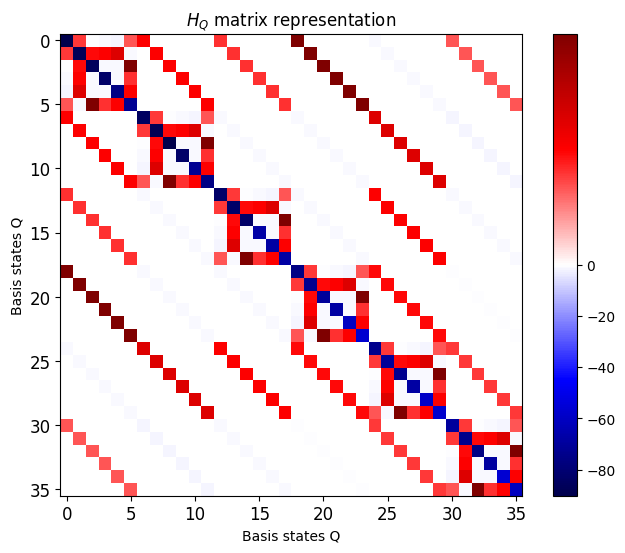

In [339]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = hamiltonian_qq.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

How many two-body operators cannot be represented as a partial quasiparticle interaction? 

In [10]:
print(QPC.couples)

[[0, 3], [1, 2], [4, 5], [6, 9], [7, 8], [10, 11]]


### Get $H_Q$, $H_{RQ}$, $H_{QR}$ and $H_{RR}$ in the nn-pp/np framework

#### Imports

In [183]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverter


#### Hyperparameters of the system, select the nucleus

Set the Interaction and the subshells

In [12]:
file_name='data/cki' #select the file with the single particle energies and two-body matrix elements
# initialize the class that handles single particle states
# load the twobody matrix as a dictionary
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:00<00:00, 14.12it/s]


Set the specific nucleus

In [39]:

SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a=4
nparticles_b=2
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2
# name of the nucleus
title=r'$^{10}$Be'



Compute the NSM Hamiltonian

In [40]:
# initialize the nuclear shell model hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
NSMHamiltonian.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
NSMHamiltonian.get_hamiltonian()
# compute eigenvectors and eigenvalues in the active configuration interaction
eigvals_aci,eigvecs_aci=NSMHamiltonian.get_spectrum(n_states=3)

print(eigvals_aci)

print(NSMHamiltonian.hamiltonian.shape)

Building two-body operator with 1424 terms...


100%|██████████| 1424/1424 [00:00<00:00, 16552.78it/s]

✅ Two-body operator built: shape=(51, 51), nnz=1155
[-39.4534158  -35.74941099 -34.02402475]
(51, 51)


Plot the NSM Hamiltonian

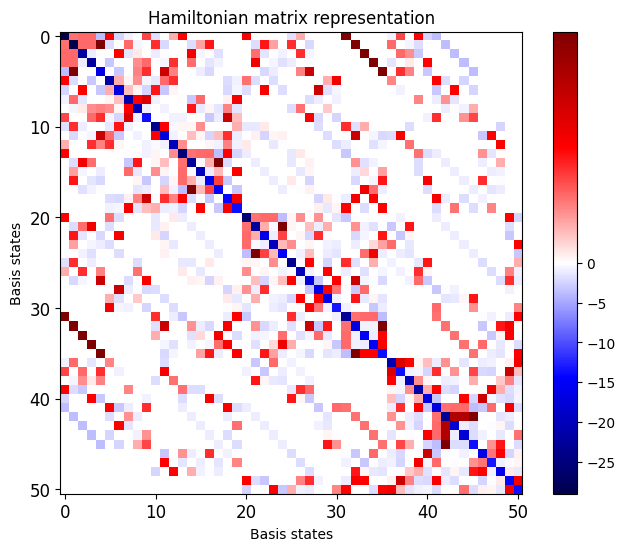

In [41]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = NSMHamiltonian.hamiltonian.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states')
plt.ylabel('Basis states')
plt.title('Hamiltonian matrix representation')
plt.show()

#### Get the Quasiparticle basis and compute the operators

In [151]:
# Initialize the quasiparticle class
QPC=QuasiParticlesConverter()
# intialize the quasiparticle modes
QPC.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
# check the basis reduction
print(QPC.quasiparticle_basis.shape)
print(QPC.rest_basis.shape)



(330, 24)
(3876, 24)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [152]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


Plot the Quasiparticle Hamiltonian

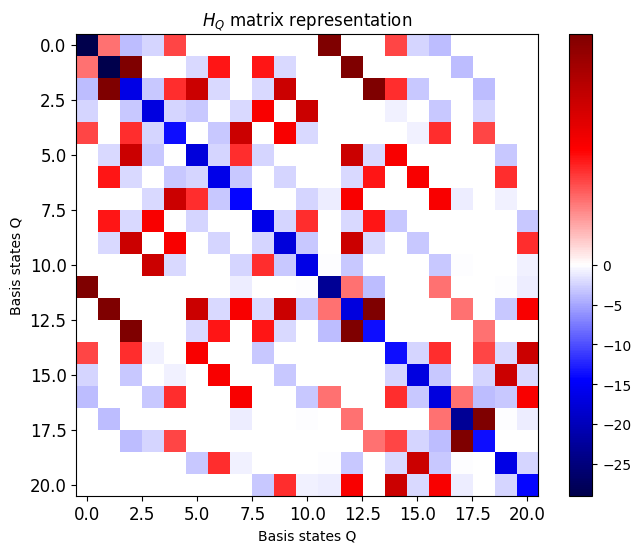

In [44]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = hamiltonian_qq.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

How many two-body operators cannot be represented as a partial quasiparticle interaction? 

In [45]:
print(QPC.couples)

[[0, 3], [1, 2], [4, 5], [6, 9], [7, 8], [10, 11], [0, 9], [1, 8], [2, 7], [3, 6], [4, 11], [5, 10]]


In [46]:
count=0
for key in twobody_matrix.keys():
    a,b,c,d=key
    
    if [min(a,b),max(a,b)] in QPC.couples or [min(c,d),max(c,d)] in QPC.couples:
        continue
    else:
        count+=1
        
print(f'Number of non quasiaparticle two-body matrix elements: {count/len(twobody_matrix)}')

Number of non quasiaparticle two-body matrix elements: 0.6685393258426966


### Exact Brillouin-Wigner method

Now we adopt the Brillouin Wigner Method for the ground state. We want to explore the convergence and the contribution of each perturbative term.

In [340]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]

single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        #diagonal_rr=scipy.sparse.diags(hamiltonian_rr.diagonal())
        #single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_full_brillouinwigner_method=[]
interaction_terms_full_brillouinwigner_method=[]
infidelities_full_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    interaction_terms_full_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_full_brillouinwigner_method.append(1-fidelity)
    history_errors_full_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))
print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)
    

100%|██████████| 20/20 [00:00<00:00, 755.74it/s]

-94.08082291108505
0.0019461393082418482 index= 19


#### Convergence with respect to the Energy of the ACI hamiltonian and discrepancy with respect to the initial fidelity of $H_Q$

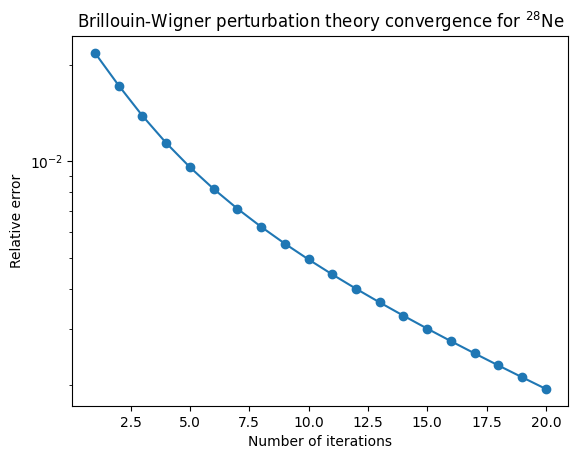

In [341]:
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}')
plt.show()

##### Fit of the curve

Model results (lower SSE and higher R2 are better):

power (logreg):
  params: (np.float64(0.03278869022875213), np.float64(0.8670848283195084))
  SSE=1.323e-04, R2=0.7684

exp:
  params: [0.02339407 0.15695244]
  stderr: [0.0008233  0.00736842]
  SSE=1.348e-05, R2=0.9764

stretched_exp:
  params: [0.03774317 0.34140147 0.57363698]
  stderr: [0.00112969 0.01940494 0.01476263]
  SSE=3.119e-07, R2=0.9995

power*exp:
  params: [0.02424648 0.28271811 0.09090172]
  stderr: [0.00025434 0.02049423 0.00489484]
  SSE=1.216e-06, R2=0.9979


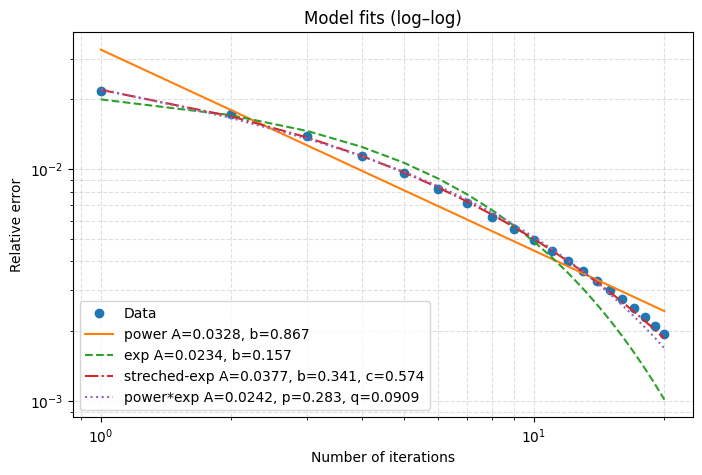

Best breakpoint (simple split) at k=4 (1-based iteration 4), total SSE=2.796e-06


In [342]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

# --- data: replace with your variables ---
x = np.arange(1, nsteps_iteration + 1)
y = np.array(history_errors_full_brillouinwigner_method)

# avoid zeros or negative y when taking logs
eps = 1e-300
y = np.clip(y, eps, None)

# --- model definitions ---
def power_model(x, A, b):
    return A * x**(-b)

def exp_model(x, A, b):
    return A * np.exp(-b * x)

def stretched_exp(x, A, b, c):
    # A * exp( - (b*x)^c )
    return A * np.exp(- (b * x)**c)

def power_times_exp(x, A, p, q):
    # A * x^{-p} * exp(-q * x)
    return A * x**(-p) * np.exp(-q * x)

# --- fitting helper that wraps curve_fit with bounds and initial guesses ---
def fit_curve(model, xdata, ydata, p0=None, bounds=(-np.inf, np.inf)):
    try:
        popt, pcov = curve_fit(model, xdata, ydata, p0=p0, bounds=bounds, maxfev=100000)
        residuals = ydata - model(xdata, *popt)
        sse = np.sum(residuals**2)
        # R^2 on y (not on log) as a simple metric
        ss_tot = np.sum((ydata - np.mean(ydata))**2)
        r2 = 1 - sse / ss_tot if ss_tot > 0 else np.nan
        return popt, np.sqrt(np.diag(pcov)), sse, r2
    except Exception as e:
        print("Fit failed for", model.__name__, ":", e)
        return None, None, np.inf, np.nan

# --- Fit models ---
results = {}

# 1) Power law: fit by linear regression on log-log (more stable)
X = np.log(x)
Y = np.log(y)
slope, intercept, rval, pval, stderr = linregress(X, Y)
b_power = -slope
A_power = np.exp(intercept)
# compute sse/r2 for consistency with other fits
y_power_pred = power_model(x, A_power, b_power)
sse_power = np.sum((y - y_power_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2_power = 1 - sse_power / ss_tot
results['power (logreg)'] = ((A_power, b_power), None, sse_power, r2_power)

# 2) Exponential (nonlinear fit)
p0 = [y[0], 0.5]  # initial A and b
popt, perr, sse, r2 = fit_curve(exp_model, x, y, p0=p0, bounds=([0,0],[np.inf,np.inf]))
results['exp'] = (popt, perr, sse, r2)

# 3) Stretched exponential
# sensible initial guesses: A ~ y0, b ~ 0.5/x_mean, c ~ 1
p0 = [y[0], 0.1, 0.0]
bounds = ([0, 0, 0], [np.inf, np.inf, 5])  # restrict c to positive
popt_se, perr_se, sse_se, r2_se = fit_curve(stretched_exp, x, y, p0=p0, bounds=bounds)
results['stretched_exp'] = (popt_se, perr_se, sse_se, r2_se)

# 4) power * exponential
p0 = [y[0], 0.5, 0.1]
bounds = ([0, 0, 0], [np.inf, 5, np.inf])
popt_pe, perr_pe, sse_pe, r2_pe = fit_curve(power_times_exp, x, y, p0=p0, bounds=bounds)
results['power*exp'] = (popt_pe, perr_pe, sse_pe, r2_pe)

# --- Print results ---
print("Model results (lower SSE and higher R2 are better):")
for name, (popt, perr, sse, r2) in results.items():
    print(f"\n{name}:")
    if popt is None:
        print("  fit failed")
    else:
        print("  params:", popt)
        if perr is not None:
            print("  stderr:", perr)
        print(f"  SSE={sse:.3e}, R2={r2:.4f}")

# --- Plot data and model fits ---
plt.figure(figsize=(8,5))
plt.loglog(x, y, 'o', label='Data')

# Power-law (from logreg)
plt.loglog(x, y_power_pred, '-', label=f'power A={A_power:.3g}, b={b_power:.3g}')

# Exponential (if fit succeeded)
if results['exp'][0] is not None:
    Aexp, bexp = results['exp'][0]
    plt.loglog(x, exp_model(x, Aexp, bexp), '--', label=f'exp A={Aexp:.3g}, b={bexp:.3g}')

# Stretched exponential
if results['stretched_exp'][0] is not None:
    Ase, bse, cse = results['stretched_exp'][0]
    plt.loglog(x, stretched_exp(x, Ase, bse, cse), '-.', label=f'streched-exp A={Ase:.3g}, b={bse:.3g}, c={cse:.3g}')

# power * exp
if results['power*exp'][0] is not None:
    Ape, ppe, qpe = results['power*exp'][0]
    plt.loglog(x, power_times_exp(x, Ape, ppe, qpe), ':', label=f'power*exp A={Ape:.3g}, p={ppe:.3g}, q={qpe:.3g}')

plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title('Model fits (log–log)')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()

# --- Optional: check for a breakpoint (simple brute-force) ---
# Try splitting the data at every candidate k and fit power-laws to left/right segments,
# pick k that minimizes total SSE.
xmin_seg = 3  # minimum points in a segment
best_k, best_sse = None, np.inf
for k in range(xmin_seg, len(x)-xmin_seg):
    # fit left (log-linear)
    xl, yl = x[:k], y[:k]
    Xl, Yl = np.log(xl), np.log(yl)
    slope_l, intercept_l, *_ = linregress(Xl, Yl)
    Al, bl = np.exp(intercept_l), -slope_l
    pred_l = power_model(xl, Al, bl)
    sse_l = np.sum((yl - pred_l)**2)
    # fit right
    xr, yr = x[k:], y[k:]
    Xr, Yr = np.log(xr), np.log(yr)
    slope_r, intercept_r, *_ = linregress(Xr, Yr)
    Ar, br = np.exp(intercept_r), -slope_r
    pred_r = power_model(xr, Ar, br)
    sse_r = np.sum((yr - pred_r)**2)
    if sse_l + sse_r < best_sse:
        best_sse = sse_l + sse_r
        best_k = k

print(f"Best breakpoint (simple split) at k={best_k} (1-based iteration {best_k}), total SSE={best_sse:.3e}")


##### How the state changes to get better accuracies in the ground state energy. We should expect a large change in the structure of the GS state, since the energy gets extremelly good results. However what we get is a small deviation in the structure of the Wavefunction and a large discrepancy in the structure of the Hamiltonian.

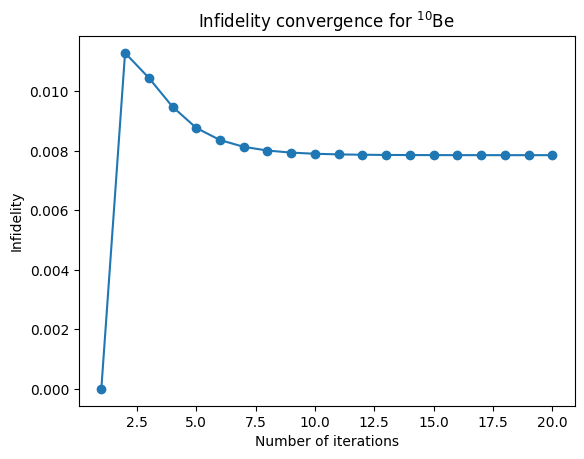

In [11]:
plt.plot(range(1,nsteps_iteration+1),infidelities_full_brillouinwigner_method,'-o')
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.title(f'Infidelity convergence for {title}')
plt.show()

Going into this direction, we can compute the expectation value of $\ket{\Psi_{Q0}}$ with respect to the $H_Q^{(N)}$ to get how different is the energy estimation

In [18]:
print('energies with respect to psiq_order0',psiq_order0.T @ (hamiltonian_qq+ interaction_terms_full_brillouinwigner_method[-1]) @ psiq_order0)

energies with respect to psiq_order0 [[-144.68529103]]


#### Investigate the structure and the coefficients of the $\Delta H_Q$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

for idx,delta_hamiltonian in enumerate(interaction_terms_full_brillouinwigner_method[1:]):
    
    if idx % 5 ==0:
        plt.figure(figsize=(8,6))

        # Hamiltonian as array and masked array
        H = delta_hamiltonian.toarray()
        H_masked = np.ma.masked_where(H == 0, H)

        # colormap + normalization
        cmap = plt.cm.coolwarm
        cmap.set_bad(color='white')
        norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())

        # plot
        im = plt.imshow(H_masked, cmap=cmap, norm=norm)

        # single colorbar
        plt.colorbar(im)

        # --- Add numbers on top of cells ---
        nrows, ncols = H.shape
        for i in range(nrows):
            for j in range(ncols):
                if H[i, j] != 0:   # skip zeros
                    plt.text(
                        j, i, f"{H[i, j]:.2f}",        # number with 2 decimals
                        ha="center", va="center",
                        color="black", fontsize=8      # adjust readability
                    )

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Basis states Q')
        plt.ylabel('Basis states Q')
        plt.title(r'$\Delta H_Q$ matrix representation')

        plt.tight_layout()
        plt.show()



#### Count the N-Quasiparticle body terms

We count the flips generater by the terms of the Hamiltonian. This can indicate the non-locality of the effective Quasiparticle Hamiltonian

In [ ]:
count_0=0
count_1=0
count_2=0
count_3=0
count_4=0
for a,base_a in enumerate(QPC.quasiparticle_basis):
    for b,base_b in enumerate(QPC.quasiparticle_basis):
        if np.abs(base_a-base_b).sum()==2 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_1+=1
        if np.abs(base_a-base_b).sum()==0 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_0+=1
            
        if np.abs(base_a-base_b).sum()==4 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_2+=1
        if np.abs(base_a-base_b).sum()==6 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            print(base_a,base_b)
            count_3+=1
        if np.abs(base_a-base_b).sum()==8 and interaction_terms_full_brillouinwigner_method[-1][a,b]!=0:
            count_4+=1
print(count_0,count_1//2,count_2//2,count_3//2,count_4//2)

### Brillouin-Wigner method with mean field approximation of $H_{RR}$

Now we adopt the Brillouin Wigner Method for the ground state. We want to explore the convergence and the contribution of each perturbative term.

In [184]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations_meanfield=[]

single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        diagonal_rr=scipy.sparse.diags(hamiltonian_rr.diagonal())
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations_meanfield.append(update)  # Store result
    
history_errors_meanfield_brillouinwigner_method=[]
interaction_terms_meanfield_brillouinwigner_method=[]
infidelities_meanfield_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations_meanfield[j]/e**(j+1)
    interaction_terms_meanfield_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_meanfield_brillouinwigner_method.append(1-fidelity)
    history_errors_meanfield_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))

print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

100%|██████████| 20/20 [00:00<00:00, 256.52it/s]

-129.88383074002164
0.018835239336493868 index= 19


#### Convergence with respect to the Energy of the ACI hamiltonian and discrepancy with respect to the initial fidelity of $H_Q$

NameError: name 'history_errors_full_brillouinwigner_method' is not defined

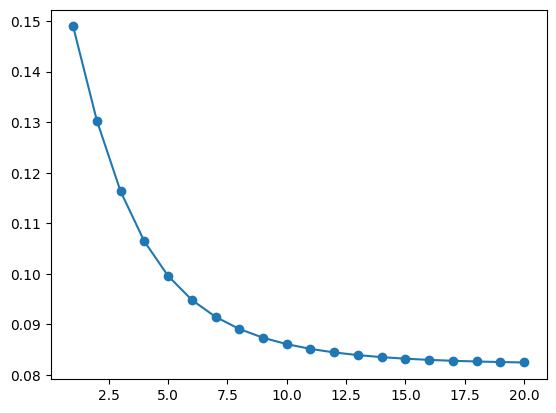

In [21]:
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o',label='full')

plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}')
plt.legend(fontsize=12)
plt.show()

##### How the state changes to get better accuracies in the ground state energy. We should expect a large change in the structure of the GS state, since the energy gets extremelly good results. However what we get is a small deviation in the structure of the Wavefunction and a large discrepancy in the structure of the Hamiltonian.

NameError: name 'infidelities_full_brillouinwigner_method' is not defined

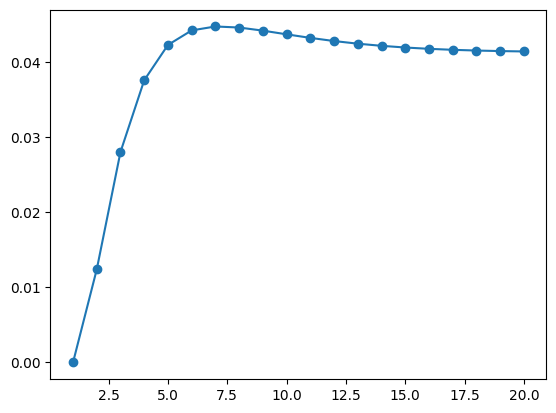

In [22]:
plt.plot(range(1,nsteps_iteration+1),infidelities_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),infidelities_full_brillouinwigner_method,'-o',label='full')
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.title(f'Infidelity convergence for {title}')
plt.legend(fontsize=12)
plt.show()

Going into this direction, we can compute the expectation value of $\ket{\Psi_{Q0}}$ with respect to the $H_Q^{(N)}$ to get how different is the energy estimation

In [24]:
print('energies with respect to psiq_order0',psiq_order0.T @ (hamiltonian_qq+ interaction_terms_meanfield_brillouinwigner_method[-1]) @ psiq_order0)

energies with respect to psiq_order0 [[-144.63016761]]


#### Investigate the structure and the coefficients of the $\Delta H_Q$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

for idx,delta_hamiltonian in enumerate(interaction_terms_meanfield_brillouinwigner_method[1:]):
    
    if idx % 5 ==0:
        plt.figure(figsize=(8,6))

        # Hamiltonian as array and masked array
        H = delta_hamiltonian.toarray()
        H_masked = np.ma.masked_where(H == 0, H)

        # colormap + normalization
        cmap = plt.cm.coolwarm
        cmap.set_bad(color='white')
        norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())

        # plot
        im = plt.imshow(H_masked, cmap=cmap, norm=norm)

        # single colorbar
        plt.colorbar(im)

        # --- Add numbers on top of cells ---
        nrows, ncols = H.shape
        for i in range(nrows):
            for j in range(ncols):
                if H[i, j] != 0:   # skip zeros
                    plt.text(
                        j, i, f"{H[i, j]:.2f}",        # number with 2 decimals
                        ha="center", va="center",
                        color="black", fontsize=8      # adjust readability
                    )

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Basis states Q')
        plt.ylabel('Basis states Q')
        plt.title(r'$\Delta H_Q$ matrix representation')

        plt.tight_layout()
        plt.show()



#### Count the N-Quasiparticle body terms

We count the flips generater by the terms of the Hamiltonian. This can indicate the non-locality of the effective Quasiparticle Hamiltonian

In [24]:
count_0=0
count_1=0
count_2=0
count_3=0
count_4=0
for a,base_a in enumerate(QPC.quasiparticle_basis):
    for b,base_b in enumerate(QPC.quasiparticle_basis):
        if np.abs(base_a-base_b).sum()==2 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            count_1+=1
        if np.abs(base_a-base_b).sum()==0 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            count_0+=1
            
        if np.abs(base_a-base_b).sum()==4 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            count_2+=1
        if np.abs(base_a-base_b).sum()==6 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            print(base_a,base_b,interaction_terms_meanfield_brillouinwigner_method[-1][a,b])
            count_3+=1
        if np.abs(base_a-base_b).sum()==8 and interaction_terms_meanfield_brillouinwigner_method[-1][a,b]!=0:
            print(base_a,base_b,interaction_terms_meanfield_brillouinwigner_method[-1][a,b])
            count_4+=1
print(count_0,count_1//2,count_2//2,count_3//2,count_4//2)

225 1800 7048 0 0


### Brillouin-Wigner method with mean field UNIFORM approximation of $H_{RR}$

#### Initialize the uniform mean field $H_{RR}$ matrix

In [18]:
from scipy.sparse import lil_matrix,identity
hamiltonian_mfhf=np.average(hamiltonian_rr.diagonal())*identity(QPC.rest_basis.shape[0])


    

Now, let's try to compute the correction using this effective diagonal Hamiltonian and lets see what Happens.

In [19]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]

single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        diagonal_rr=hamiltonian_mfhf
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_meanfield_uniform_brillouinwigner_method=[]
interaction_terms_meanfield_uniform_brillouinwigner_method=[]
infidelities_meanfield_uniform_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    interaction_terms_meanfield_uniform_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_meanfield_uniform_brillouinwigner_method.append(1-fidelity)
    history_errors_meanfield_uniform_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))

print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 181.45it/s]

-82.81898591992571
0.10731549836038697 index= 19


#### Convergence with respect to the Energy of the ACI hamiltonian and discrepancy with respect to the initial fidelity of $H_Q$

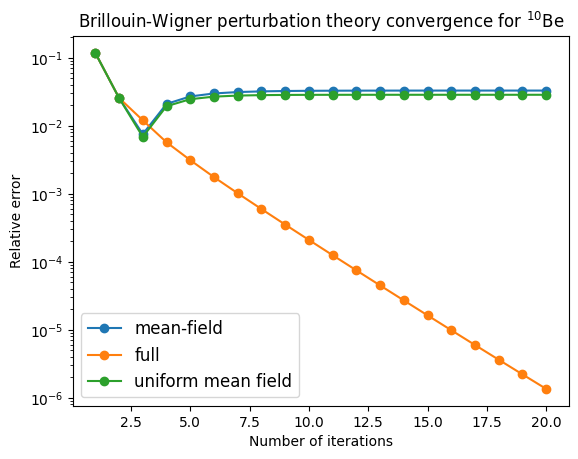

In [19]:
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o',label='full')
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_uniform_brillouinwigner_method,'-o',label='uniform mean field')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}')
plt.legend(fontsize=12)
plt.show()

##### How the state changes to get better accuracies in the ground state energy. We should expect a large change in the structure of the GS state, since the energy gets extremelly good results. However what we get is a small deviation in the structure of the Wavefunction and a large discrepancy in the structure of the Hamiltonian.

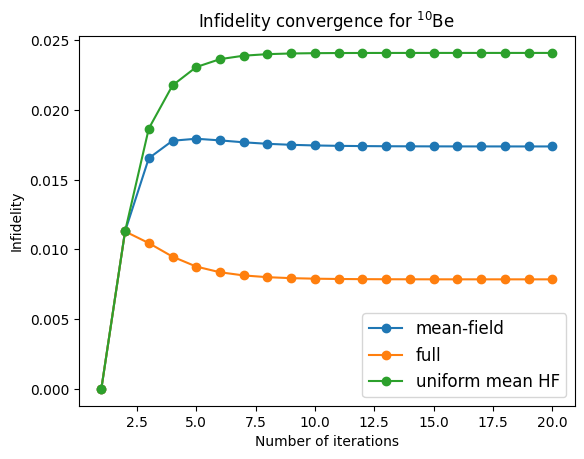

In [20]:
plt.plot(range(1,nsteps_iteration+1),infidelities_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),infidelities_full_brillouinwigner_method,'-o',label='full')
plt.plot(range(1,nsteps_iteration+1),infidelities_meanfield_uniform_brillouinwigner_method,'-o',label='uniform mean HF')
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.title(f'Infidelity convergence for {title}')
plt.legend(fontsize=12)
plt.show()

Going into this direction, we can compute the expectation value of $\ket{\Psi_{Q0}}$ with respect to the $H_Q^{(N)}$ to get how different is the energy estimation

In [20]:
print('energies with respect to psiq_order0',psiq_order0.T @ (hamiltonian_qq+ interaction_terms_meanfield_brillouinwigner_method[-1]) @ psiq_order0)

energies with respect to psiq_order0 [[-144.63016761]]


Let's look at the structure of the Quasiparticle Hamiltonian

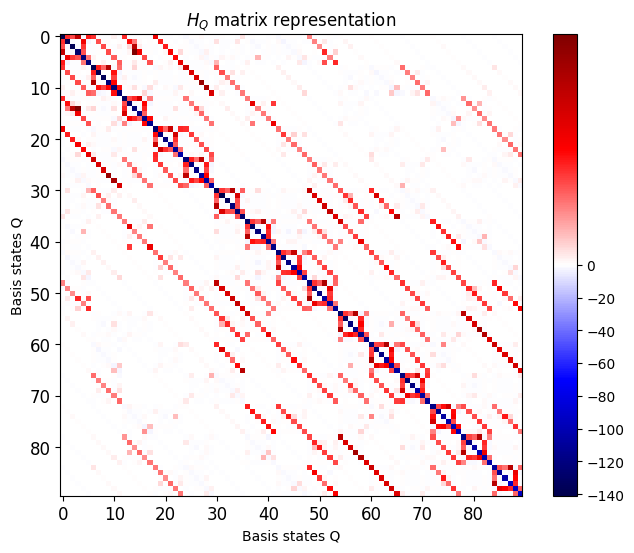

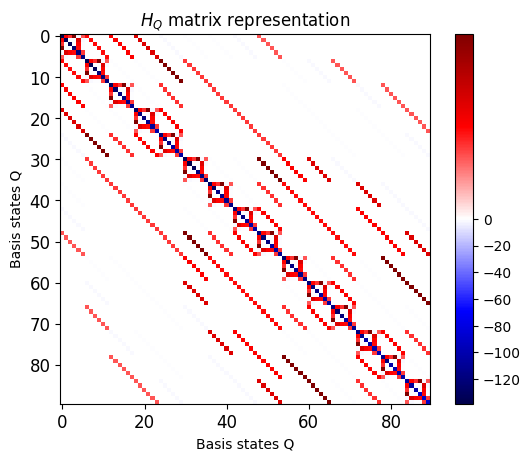

In [21]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H =hamiltonian_qq.toarray()+ interaction_terms_meanfield_uniform_brillouinwigner_method[-1].toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

# wrap the Hamiltonian in a masked array to hide zeros
H =hamiltonian_qq.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

##### Plot the evolution of each element in the Hamiltonian

In [22]:
elements_vs_t=[]
index=[]
for a in range(hamiltonian_qq.shape[0]):
    for b in range(a,hamiltonian_qq.shape[0]):
        index.append([a,b])
        element=[]
        for t in range(nsteps_iteration):
            if t==0:
                element.append(hamiltonian_qq[a,b])
            else:
                element.append(hamiltonian_qq[a,b]+interaction_terms_meanfield_uniform_brillouinwigner_method[t][a,b])
        elements_vs_t.append(np.asarray(element))

elements_vs_t=np.asarray(elements_vs_t)                

In [ ]:
print(elements_vs_t.shape)
for i,a in enumerate(elements_vs_t):
    if np.abs(a[-1]-a[0])>0.1:
        print(index[i])
        plt.plot(np.arange(nsteps_iteration),a)
        plt.show()

### Using only 2-body quasiparticle connections in $H_{QR}$ for the Brillouin-Wigner Method

#### Imports

In [185]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverterOnlynnpp


#### Hyperparameters of the system, select the nucleus

We need to consider the Particle subsector related to the 2-quasiparticle modes nn-pp, therefore we need to take into account the $N_n=2$ and $Z_p=2$ and $N_n=4$, $Z_p=0$

In [186]:
# 
SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a_twobody=2
nparticles_b_twobody=2
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2




Compute the NSM Hamiltonian that corresponds to the $^{20}$ Ne

In [187]:
# initialize the nuclear shell model hamiltonian
Hamiltonian2bodysector=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a_twobody,nparticles_b=nparticles_b_twobody,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
Hamiltonian2bodysector.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
Hamiltonian2bodysector.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
Hamiltonian2bodysector.get_hamiltonian()


print(Hamiltonian2bodysector.hamiltonian.shape)

Building two-body operator with 16496 terms...


100%|██████████| 16496/16496 [00:00<00:00, 19795.53it/s]

✅ Two-body operator built: shape=(640, 640), nnz=54112
(640, 640)


#### Get the Quasiparticle basis and compute the operators

In [188]:
# Initialize the quasiparticle class
QPC2body=QuasiParticlesConverterOnlynnpp()
# intialize the quasiparticle modes
QPC2body.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC2body.get_the_basis_matrix_transformation(basis=Hamiltonian2bodysector.basis)
# check the basis reduction
print(QPC2body.quasiparticle_basis.shape)
print(QPC2body.rest_basis.shape)



(36, 12)
(604, 24)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [189]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T
hamiltonian_qr_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2restofstates.T
hamiltonian_rq_2b=QPC2body.particles2restofstates @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T
hamiltonian_rr_2b=QPC2body.particles2restofstates @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2restofstates.T



#### Investigate the magnitude of $H_{QR}$

We can check that the magnitude of the couplings of the $H_{QR}$ is similar to the $H_{QR}$ of a generic many-body hamiltonian. Maybe it's important to check the connectivity to figure out if more or less we can reduce it randomly or not.

In [190]:
count=0
for q_index in range(hamiltonian_qr_2b.shape[0]):
    for r_index in range(hamiltonian_qr_2b.shape[1]):
        if hamiltonian_qr_2b[q_index,r_index]!=0:
            # print('q_index=',q_index,' r_index=',r_index,' value=',hamiltonian_qr_2b[q_index,r_index])
            # print('\n')
            count+=1

print(count)

2555


In [165]:
print(hamiltonian_qr.shape,hamiltonian_qr_2b.shape)

(225, 28278) (36, 604)


In [191]:
print((1-2/12)*(1-2/12))
print((1-4/12)*(1-4/12))
print((1-4/12)*(1-4/12))



0.6944444444444445
0.44444444444444453
0.44444444444444453


In [ ]:
for q_index in range(QPC.quasiparticle_basis.shape[0]):
    count=0
    for line in range(hamiltonian_qr.shape[1]):
        if hamiltonian_qr[q_index,line]!=0:
            count+=1
    print(count)

    count2=0
    for line in range(hamiltonian_qr_2b.shape[1]):
        if hamiltonian_qr_2b[q_index,line]!=0:
            count2+=1
    print(count2)
    
    print('ratio=',count2/count)





In [ ]:
print(hamiltonian_qr_2b)

#### Create the two-body corrections using the sampled reconstruction of the $H_{RR}$ mean field term and keeping the off diagonal transition of the two-body $H_{RR}$. 

In [199]:
print(range_energies_rr.shape,probability_distribution_diag_hamiltonian_rr.shape)
new_diagonal_contribution=np.random.choice(range_energies_rr[:-1],size=hamiltonian_rr_2b.shape[0],p=probability_distribution_diag_hamiltonian_rr)

#delta_energy_samples=np.max(hamiltonian_rr.diagonal())-hamiltonian_rr.diagonal()
#delta_energy_samples=hamiltonian_rr.diagonal()-np.min(hamiltonian_rr.diagonal())

#p_energy=delta_energy_samples/np.sum(delta_energy_samples)

#new_diagonal_contribution=np.random.choice(hamiltonian_rr.diagonal(),size=hamiltonian_rr_2b.shape[0],p=p_energy)

(201,) (200,)


In [200]:
from scipy.sparse import lil_matrix
#hamiltonian_rr_2body=lil_matrix((QPC2body.rest_basis.shape[0],QPC2body.rest_basis.shape[0]))


# in order to take into account of the extensive magnitude of the energy
for r in range(hamiltonian_rr_2b.shape[0]):
    #gamma=np.random.normal(0,np.std(hamiltonian_rr.diagonal()))
    hamiltonian_rr_2b[r,r]=new_diagonal_contribution[r]#(hamiltonian_rr_2b[r,r]-mean_2b_hamiltonian_rr)*(np.average(hamiltonian_rr.diagonal()))/(mean_2b_hamiltonian_rr)

    
    print(hamiltonian_rr_2b[r,r])
    print(hamiltonian_rr[r,r],'\n')

-91.01404130148813
-106.22944384920635 

-101.49077738809528
-101.20254408730167 

-81.34320799077383
-98.07438319444441 

-87.79043019791669
-109.11239057539684 

-83.22364780119051
-108.0196628968254 

-79.46276818035717
-106.16699182539682 

-87.2531616806548
-107.97626414682549 

-95.58082369821432
-101.26191583333329 

-95.04355518095241
-99.26916422619044 

-86.98452742202385
-100.6766113492063 

-80.80593947351193
-100.53653081349208 

-91.28267556011909
-96.25922438492066 

-88.05906445654765
-94.55793089285712 

-94.77492092232146
-99.56158722222216 

-69.79193486964289
-102.46556198412691 

-93.70038388779766
-99.39556859126978 

-96.65536073273813
-95.22799323412698 

-103.37121719851194
-97.9639746031746 

-80.53730521488097
-96.36848033730166 

-88.8649672324405
-92.43197700396823 

-96.38672647410718
-89.05103015873014 

-82.6863792839286
-91.0171603769841 

-96.38672647410718
-91.80378888888886 

-91.55130981875004
-85.61934444444438 

-101.49077738809528
-107.4555525992

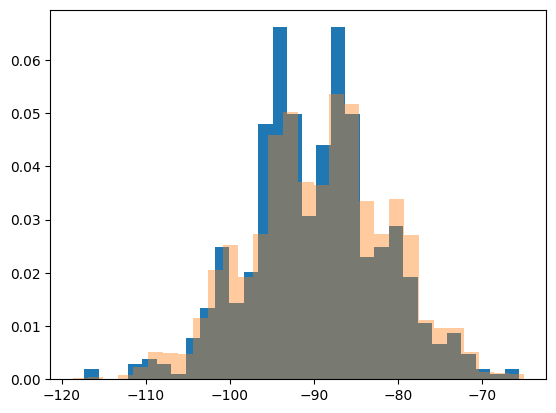

In [201]:
plt.hist(hamiltonian_rr_2b.diagonal(),bins=30,density=True)
plt.hist(hamiltonian_rr.diagonal(),bins=30,alpha=0.4,density=True)
plt.show()

In [ ]:
for i in range(hamiltonian_qr_2b.shape[0]):
    for j in range(hamiltonian_qr_2b.shape[1]):
        print('i,j',i,j)
        print(hamiltonian_qr_2b[i,j])
        print(hamiltonian_qr[i,j])
        print('\n')

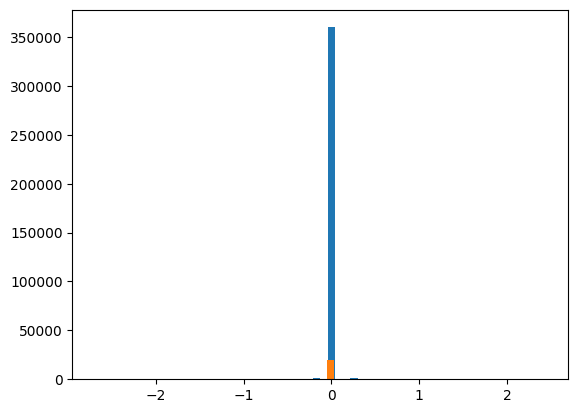

In [144]:
plt.hist(hamiltonian_qr.toarray().flatten(),bins=60)
plt.hist(hamiltonian_qr_2b.toarray().flatten(),bins=60)
plt.show()

Create the corrections as two-body terms to upload using the Hardcore-Boson Model

In [202]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
values,psiq_order0=eigsh(hamiltonian_qq_2b,k=1)
e=values[0]
approximations_as_dictionary=[]
approximations_as_matrix=[]

single_term = hamiltonian_rq_2b  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        diagonal_rr=hamiltonian_rr_2b
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr_2b @ single_term)
    twobody_quasiparticle={}
    for q,base_q in enumerate(QPC2body.quasiparticle_basis):
        for p,base_p in enumerate(QPC2body.quasiparticle_basis):
            a_q,b_q=np.nonzero(base_q)[0]
            a_p,b_p=np.nonzero(base_p)[0]
            q_max=np.max([a_q,b_q])
            q_min=np.min([a_q,b_q])
            p_max=np.max([a_p,b_p])
            p_min=np.min([a_p,b_p])
            
            if (q_max == p_max ) and (q_min == p_min) :
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]#/(nparticles_a*nparticles_b/4)

            elif (q_max==p_max) and (q_min!=p_min) and (q_max < size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]#/(nparticles_a/2)
            
            elif (q_max==p_max) and (q_min!=p_min) and (q_max > size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]#/(nparticles_b/2)
            
            elif (q_min==p_min) and (q_max!=p_max) and (q_min < size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]#/(nparticles_a/2)
            
            elif (q_min==p_min) and (q_max!=p_max) and (q_min > size_a/2):
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]#/(nparticles_b/2)
            
            else:
                twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]
            
            
            
    approximations_as_dictionary.append(twobody_quasiparticle)
    approximations_as_matrix.append(update)
    


100%|██████████| 20/20 [00:00<00:00, 27.91it/s]


#### Use Brillouin-Wigner with the two-body correction effect.

##### Imports

In [203]:
from NSMFermions.utils_quasiparticle_approximation import HardcoreBosonsBasis

# we introduce a class to build up quasiparticle operators on the quasiparticle basis
# it works as the FermiHubbardHamiltonian class, the only difference is the basis of the single site operator that corresponds with the S+ S- format, instead of c^dag c
HBB=HardcoreBosonsBasis(QPC.quasiparticle_basis)




We want to write the correction operators in the two-body basis as operator in this many-body basis, in this way it is possible to use them and to compare with the exact Brillouin-Wigner set of operators.

In [204]:
from tqdm import tqdm

approximations_truncated=[]

tbar=tqdm(enumerate(approximations_as_dictionary))

for _,interaction_dictionary in tbar:
    operator=0.
    tbar2=tqdm(interaction_dictionary.keys())
    for key in tbar2:
        a,b,c,d=key
        operator+=((1-nparticles_a/size_a)*(1-nparticles_b/size_b))/((1-2/12)*(1-2/12))*HBB.adag_adag_a_a_matrix_optimized(a,b,c,d)*interaction_dictionary[key]
    approximations_truncated.append(operator)    

100%|██████████| 1296/1296 [00:00<00:00, 5302.91it/s]
20it [00:05,  3.93it/s]


Here we want to compare the magnitude of the matrix elements of these corrections just to be sure that the corrections on the overcounting makes sense. The N-body terms counts only one whereas the two-body terms have a overcounting in the connection with the many-body state

In [ ]:
for i in range(approximations_meanfield[0].shape[0]):
    for j in range(approximations_meanfield[0].shape[0]):
        if approximations_meanfield[0][i,j]!=0:
            print('ij=',i,j)
            print(approximations_meanfield[0][i,j])
            print(approximations_truncated[0][i,j])
            print('\n')

In [206]:
print(approximations_truncated[0])


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 15281 stored elements and shape (225, 225)>
  Coords	Values
  (0, 0)	67.42584294007733
  (0, 1)	2.0786867100529838
  (0, 2)	-0.9665363781487761
  (0, 3)	2.279254821062709
  (0, 4)	-1.2855557078714979
  (0, 6)	-4.141994918155913
  (0, 7)	3.2530805524395645
  (0, 10)	5.720407205518891
  (0, 11)	-1.8097149447787118
  (0, 15)	-3.424231242706855
  (0, 16)	-0.09678531717170237
  (0, 17)	0.022611208231790744
  (0, 18)	-0.02322649057496184
  (0, 19)	0.5662579318312961
  (0, 22)	-1.1154236526947232
  (0, 25)	-0.2619818929142366
  (0, 26)	0.13090102528160788
  (0, 30)	-4.668530756443733
  (0, 31)	-0.9071040432000004
  (0, 32)	1.3606560648000003
  (0, 33)	-0.08866831905920297
  (0, 34)	0.02817178672365412
  (0, 37)	-0.003024951740952386
  (0, 40)	-0.023993766433139094
  (0, 41)	0.06587543310971807
  :	:
  (224, 178)	-0.02322649057496183
  (224, 179)	2.230593132007212
  (224, 187)	-0.010010843842963517
  (224, 190)	-0.000599695360000000

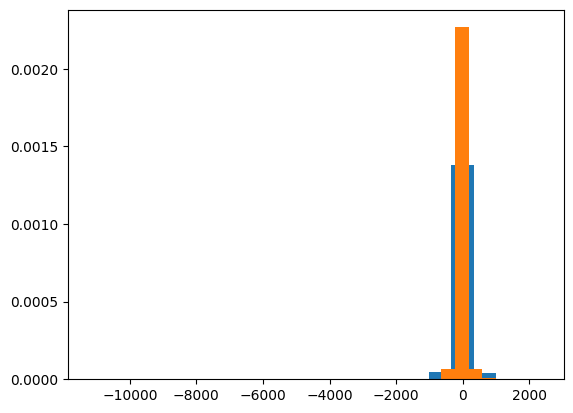

In [207]:

# we select an iteration term
idx_iteration=1
# we compare the matrix elements of each correction using an histogram
_=plt.hist(approximations[idx_iteration].toarray().flatten(),bins=20,density=True)
_=plt.hist(approximations_truncated[idx_iteration].toarray().flatten(),bins=20,density=True)


#### Now we compute the iteration using this truncation, good luck

In [208]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]

    
history_errors_truncated_brillouinwigner_method=[]
interaction_terms_truncated_brillouinwigner_method=[]
infidelities_truncated_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations_truncated[j]/e**(j+1)
    interaction_terms_truncated_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_truncated_brillouinwigner_method.append(1-fidelity)
    history_errors_truncated_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))
print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

100%|██████████| 20/20 [00:00<00:00, 300.05it/s]

-128.38215664694954
0.030179143298433835 index= 19


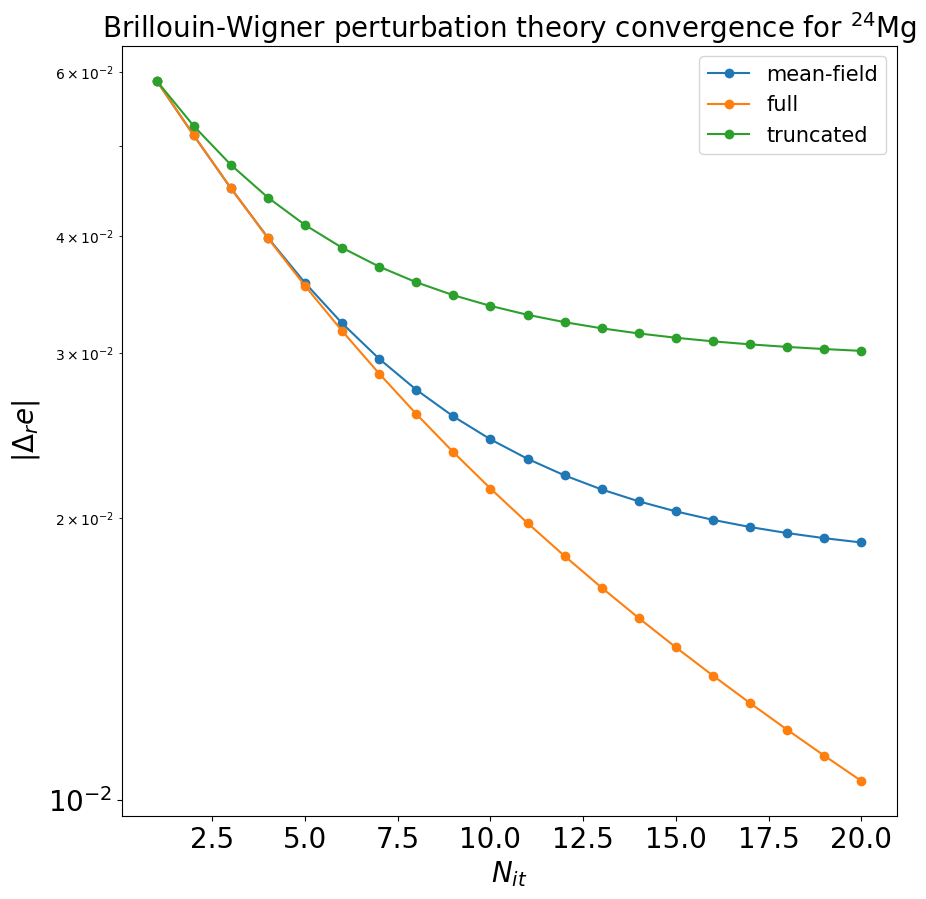

In [210]:
plt.figure(figsize=(10,10))
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_brillouinwigner_method,'-o',label='mean-field')
plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o',label='full')
#plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_uniform_brillouinwigner_method,'-o',label='uniform mean field')
plt.plot(range(1,nsteps_iteration+1),history_errors_truncated_brillouinwigner_method,'-o',label='truncated')
plt.yscale('log')
plt.xlabel(r'$N_{it}$',fontsize=20)
plt.ylabel(r'$|\Delta_r e|$',fontsize=20)
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}',fontsize=20)
plt.tick_params(labelsize=20)
plt.legend(fontsize=15)
plt.show()

### Using only 2-body quasiparticle connections in $H_{QR}$ for the Brillouin-Wigner Method + uniform MF of $H_{RR}$

#### Imports

In [343]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverterOnlynnpp
from src.hartree_fock_library import HFEnergyFunctionalNuclear
import torch.optim as optim

#### First, we need to solve the Hartree-Fock optimization for the nucleus, to extract the HF Energy and the density

In [344]:
# we compute the m values array
m_values=[]
for sp in SPS.state_encoding:
    n,l,j,m,t,tz=sp
    m_values.append(m)

m_values=np.array(m_values)


# we initialize the Hartree-Fock model as a pytorch module
model=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=nparticles_a,num_protons=nparticles_b,neutron_indices=0,proton_indices=size_a,m_values=m_values,multiplier_m_values=0)
# initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# training loop
num_steps = 600
# to get more info about this just go to the pytorch documentation
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        # see how it goes
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

E1: -20.734318926198718, E2: -48.757616782617454, E_constrain: 0.0
Step    0 | Energy = -69.491936
E1: -21.344408269177023, E2: -48.992084096700495, E_constrain: 0.0
E1: -21.92230025834379, E2: -49.23040902502375, E_constrain: 0.0
E1: -22.4735415762257, E2: -49.45797203770729, E_constrain: 0.0
E1: -22.993807316712804, E2: -49.66953890054075, E_constrain: 0.0
E1: -23.472490978852477, E2: -49.85895325905612, E_constrain: 0.0
E1: -23.903359513517323, E2: -50.02245990555565, E_constrain: 0.0
E1: -24.287457044714962, E2: -50.16003478357155, E_constrain: 0.0
E1: -24.632793353532577, E2: -50.27470941879969, E_constrain: 0.0
E1: -24.950207782456857, E2: -50.371385260917805, E_constrain: 0.0
E1: -25.248861176194595, E2: -50.45533603943234, E_constrain: 0.0
E1: -25.53474350237104, E2: -50.53126162345768, E_constrain: 0.0
E1: -25.811029227724767, E2: -50.60283768599332, E_constrain: 0.0
E1: -26.07909553586266, E2: -50.67268085106515, E_constrain: 0.0
E1: -26.339337210682576, E2: -50.7424908057595

torch.Size([24, 24]) tensor(10., dtype=torch.float64, grad_fn=<SumBackward0>)
torch.Size([24, 24]) tensor(2.0000, dtype=torch.float64, grad_fn=<SumBackward0>)


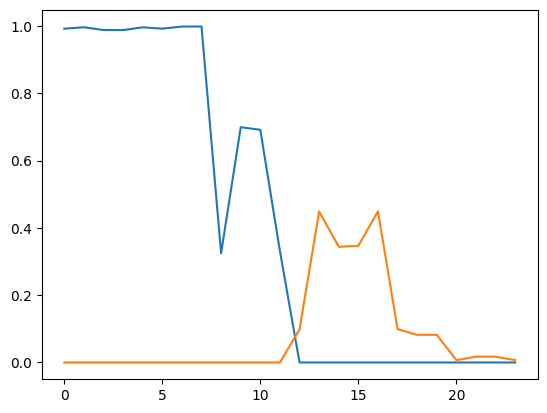

E1: -32.903956851911616, E2: -57.687784537012014, E_constrain: 0.0
tensor(-90.5917, dtype=torch.float64, grad_fn=<AddBackward0>)
E1: -32.903956851911616, E2: -57.687784537012014, E_constrain: 0.0
-90.59174138892362


In [345]:
print(model.rho_n.shape,model.rho_n.diagonal().sum())
print(model.rho_p.shape,model.rho_p.diagonal().sum())
plt.plot(model.rho_n.diagonal().detach().numpy())
plt.plot(model.rho_p.diagonal().detach().numpy())
plt.show()

full_density_hf=np.zeros((size_a+size_b))
full_density_hf[:size_a]=model.rho_n.diagonal().detach().numpy()[:size_a]
full_density_hf[size_a:]=model.rho_p.diagonal().detach().numpy()[size_a:]

print(model())

energy_hf=model().item()

print(energy_hf)

#### Hyperparameters of the system, select the nucleus

We need to consider the Particle subsector related to the 2-quasiparticle modes nn-pp, therefore we need to take into account the $N_n=2$ and $Z_p=2$ and $N_n=4$, $Z_p=0$

In [346]:
# 
SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a_twobody=2
nparticles_b_twobody=2
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2




Compute the NSM Hamiltonian that corresponds to the $^{20}$ Ne

In [347]:
# initialize the nuclear shell model hamiltonian
Hamiltonian2bodysector=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a_twobody,nparticles_b=nparticles_b_twobody,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
Hamiltonian2bodysector.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
Hamiltonian2bodysector.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
Hamiltonian2bodysector.get_hamiltonian()


print(Hamiltonian2bodysector.hamiltonian.shape)

Building two-body operator with 16496 terms...


100%|██████████| 16496/16496 [00:00<00:00, 20741.62it/s]


✅ Two-body operator built: shape=(640, 640), nnz=54112
(640, 640)


#### Get the Quasiparticle basis and compute the operators

In [348]:
# Initialize the quasiparticle class
QPC2body=QuasiParticlesConverterOnlynnpp()
# intialize the quasiparticle modes
QPC2body.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC2body.get_the_basis_matrix_transformation(basis=Hamiltonian2bodysector.basis)
# check the basis reduction
print(QPC2body.quasiparticle_basis.shape)
print(QPC2body.rest_basis.shape)



(36, 12)
(604, 24)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [349]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T
hamiltonian_qr_2b=QPC2body.particles2quasiparticles @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2restofstates.T
hamiltonian_rq_2b=QPC2body.particles2restofstates @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2quasiparticles.T
#hamiltonian_rr_2b=QPC2body.particles2restofstates @ Hamiltonian2bodysector.hamiltonian @ QPC2body.particles2restofstates.T



#### Investigate the magnitude of $H_{QR}$

#### Create the two-body corrections using the mean field uniform $H_{RR}$ with the energy scale of the full many-body Hamiltonian. 

In [ ]:
from scipy.sparse import lil_matrix,identity

hamiltonian_rr_2b=energy_hf*identity(QPC2body.rest_basis.shape[0])
hamiltonian_qr_2b_pauliblockade=lil_matrix((QPC2body.quasiparticle_basis.shape[0],QPC2body.rest_basis.shape[0]))


for index_qbasis,qb in enumerate(QPC2body.quasiparticle_basis):
    quasiparticle_indices=[]
    idxs=np.nonzero(qb)[0]
    for idx in idxs:
        quasiparticle_indices.append(QPC2body.couples[idx][0])
        quasiparticle_indices.append(QPC2body.couples[idx][1])
    for index_restbasis,rb in enumerate(QPC2body.rest_basis):
        if hamiltonian_qr_2b[index_qbasis,index_restbasis]!=0:
            
            rest_indices=np.nonzero(rb)[0]
            added_indices = sorted(set(rest_indices) - set(quasiparticle_indices))  # added
            removed_indices=sorted(set(quasiparticle_indices) - set(rest_indices))
            pauli_blocking_vector_added=((1-full_density_hf[added_indices]))
            
            hamiltonian_qr_2b_pauliblockade[index_qbasis,index_restbasis]=np.prod(pauli_blocking_vector_added)*hamiltonian_qr_2b[index_qbasis,index_restbasis]
            #hamiltonian_rq_2b_pauliblockade[index_restbasis,index_qbasis]=np.prod(pauli_blocking_vector_removed)*hamiltonian_rq_2b[index_restbasis,index_qbasis]
            
hamiltonian_rq_2b_pauliblockade=hamiltonian_qr_2b_pauliblockade.T

In [351]:
print(hamiltonian_qr_2b)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2555 stored elements and shape (36, 604)>
  Coords	Values
  (0, 0)	-0.45876507936507965
  (0, 1)	1.096283198521862
  (0, 2)	0.11816984126984101
  (0, 4)	-0.027423351397426327
  (0, 5)	-0.44278468996383347
  (0, 6)	-0.2881301587301583
  (0, 11)	0.4808606694347589
  (0, 12)	0.6322793396075583
  (0, 15)	0.23103492063492015
  (0, 22)	-0.8929983991364584
  (0, 26)	0.20328479938540367
  (0, 27)	-0.5082840208321852
  (0, 28)	0.1894946496437248
  (0, 29)	0.5082840208321852
  (0, 30)	0.18949464964372487
  (0, 31)	0.20328479938540364
  (0, 32)	0.483679953708077
  (0, 33)	0.483679953708077
  (0, 34)	0.027423351397426327
  (0, 36)	-0.2245657281313674
  (0, 37)	0.23371242231056472
  (0, 38)	-0.4808606694347589
  (0, 43)	0.6762161618582865
  (0, 44)	0.2499675313975125
  (0, 47)	1.0962831985218615
  :	:
  (35, 534)	-0.11179270703329697
  (35, 536)	0.3837438166376979
  (35, 538)	-0.32893247559339583
  (35, 552)	-0.4744024744405058
  (35, 55

Create the corrections as two-body terms to upload using the Hardcore-Boson Model

In [ ]:
target_eigenvalue=0
nsteps_iteration=20
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq_2b,k=1)
e=values[0]
approximations_as_dictionary=[]
approximations_as_matrix=[]

single_term = hamiltonian_rq_2b_pauliblockade   # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        ########################################################################## GET THIS
        diagonal_rr=hamiltonian_rr_2b
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        #single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr_2b_pauliblockade  @ single_term)
    twobody_quasiparticle={}
    for q,base_q in enumerate(QPC2body.quasiparticle_basis):
        for p,base_p in enumerate(QPC2body.quasiparticle_basis):
            a_q,b_q=np.nonzero(base_q)[0]
            a_p,b_p=np.nonzero(base_p)[0]
            q_max=np.max([a_q,b_q])
            q_min=np.min([a_q,b_q])
            p_max=np.max([a_p,b_p])
            p_min=np.min([a_p,b_p])
            

            twobody_quasiparticle[(a_q,b_q,a_p,b_p)]=update[q,p]
            
            
            
    approximations_as_dictionary.append(twobody_quasiparticle)
    approximations_as_matrix.append(update)
    


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 26.88it/s]


#### Use Brillouin-Wigner with the two-body correction effect.

##### Imports

In [369]:
from NSMFermions.utils_quasiparticle_approximation import HardcoreBosonsBasis

# we introduce a class to build up quasiparticle operators on the quasiparticle basis
# it works as the FermiHubbardHamiltonian class, the only difference is the basis of the single site operator that corresponds with the S+ S- format, instead of c^dag c
HBB=HardcoreBosonsBasis(QPC.quasiparticle_basis)




We want to write the correction operators in the two-body basis as operator in this many-body basis, in this way it is possible to use them and to compare with the exact Brillouin-Wigner set of operators.

In [370]:
from tqdm import tqdm

approximations_truncated_uniform=[]

tbar=tqdm(enumerate(approximations_as_dictionary))

for _,interaction_dictionary in tbar:
    operator=0.
    tbar2=tqdm(interaction_dictionary.keys())
    for key in tbar2:
        a,b,c,d=key
        operator+=HBB.adag_adag_a_a_matrix_optimized(a,b,c,d)*interaction_dictionary[key]
    approximations_truncated_uniform.append(operator)    

100%|██████████| 1296/1296 [00:00<00:00, 6559.25it/s]
50it [00:10,  4.92it/s]


Here we want to compare the magnitude of the matrix elements of these corrections just to be sure that the corrections on the overcounting makes sense. The N-body terms counts only one whereas the two-body terms have a overcounting in the connection with the many-body state

In [371]:

for i in range(QPC.quasiparticle_basis.shape[0]):
    for j in range(QPC.quasiparticle_basis.shape[0]):
        print(approximations[0][i,j],approximations_truncated_uniform[0][i,j])

6.220693436954479 14.323414638124989
-1.6488524581312582 0.043354624706605144
2.6383766928454153 -0.8909752761266674
1.7617240746521279 2.037611495446354
0.3153805234214491 4.925866918140161
-1.6936052428534802 -0.37053119132873036
-2.963488036854011 -0.2379606435590327
0.6625930775179631 0.06727517254734208
-0.1894778996430697 -0.02285143976006698
-0.5214886201082195 -0.08821009504733635
-0.007726547498441804 -0.0014142846337876303
0.09343242221550155 0.016922019432976956
-1.1608095108143726 -0.00012628624924116376
0.19470427367630813 3.246785255530927e-05
0.0 0.0
0.0 0.0
-0.03128388700926099 -9.40456267890184e-06
0.0 0.0
-1.1838972513546642 0.0006433894181617085
0.00458542941933712 8.075176327911692e-06
0.0 0.0
0.0 0.0
-0.06060241710204644 -0.0001924010010143856
0.0 0.0
1.0608012734164203 -0.0006398762699166866
-0.02335546022557496 -1.1762846457707268e-05
0.0016279407486209563 9.746264875395217e-07
0.21529545296070254 0.00018079500342659178
0.03596509790349662 3.26550531968295e-05
-0

In [ ]:
print(approximations_truncated_uniform[0])

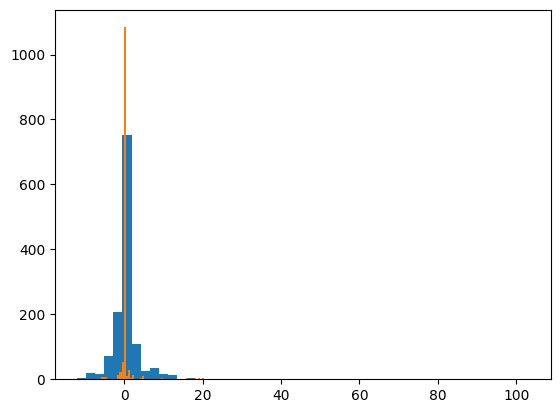

In [373]:

# we select an iteration term
idx_iteration=0
# we compare the matrix elements of each correction using an histogram
_=plt.hist(approximations[idx_iteration].toarray().flatten(),bins=50)
_=plt.hist(approximations_truncated_uniform[idx_iteration].toarray().flatten(),bins=50)

#### Now we compute the iteration using this truncation, good luck

In [374]:

# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]

    
history_errors_truncated_uniform_meanfield_brillouinwigner_method=[]
interaction_terms_truncated_uniform_meanfield_brillouinwigner_method=[]
infidelities_truncated_uniform_meanfield_brillouinwigner_method=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations_truncated_uniform[j]/e**(j+1)
    interaction_terms_full_brillouinwigner_method.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities_truncated_uniform_meanfield_brillouinwigner_method.append(1-fidelity)
    history_errors_truncated_uniform_meanfield_brillouinwigner_method.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))
print(e)
print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)

100%|██████████| 50/50 [00:00<00:00, 389.50it/s]

-95.84052021566286
0.016721561867614195 index= 49


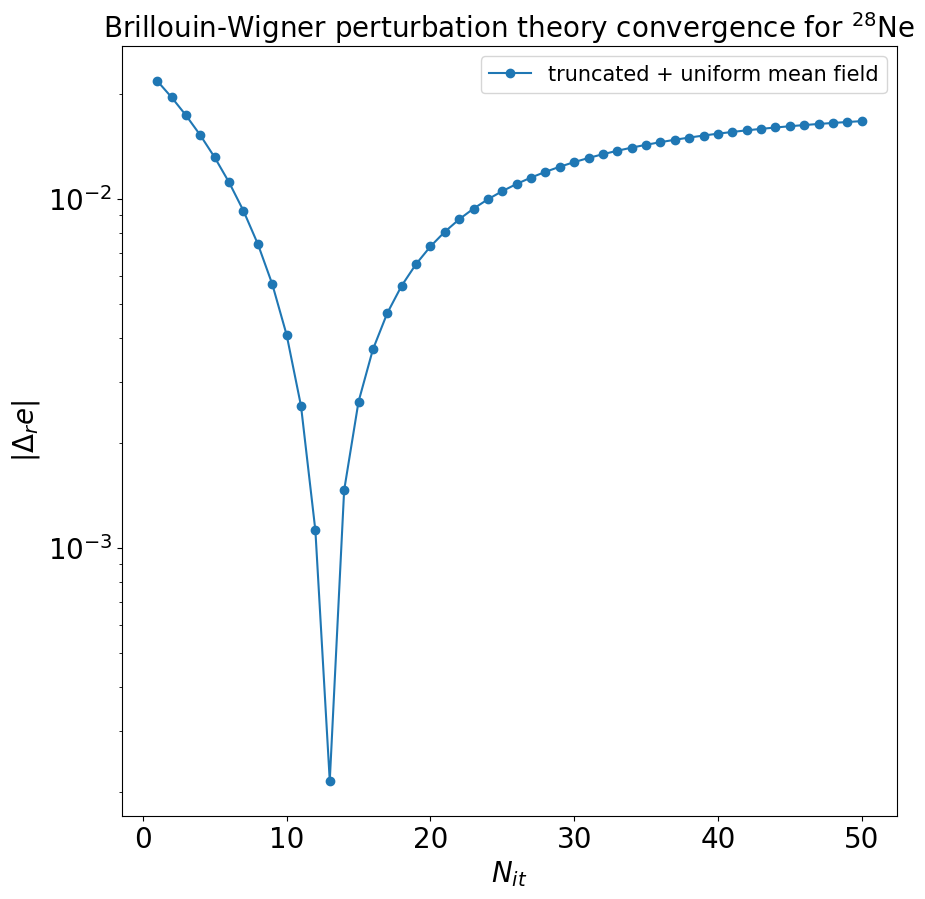

In [375]:
plt.figure(figsize=(10,10))
# here we plot the convergence of the Brillouin-Wigner perturbation theory
#plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_brillouinwigner_method,'-o',label='mean-field')
#plt.plot(range(1,nsteps_iteration+1),history_errors_full_brillouinwigner_method,'-o',label='full')
#plt.plot(range(1,nsteps_iteration+1),history_errors_meanfield_uniform_brillouinwigner_method,'-o',label='uniform mean field')
#plt.plot(range(1,nsteps_iteration+1),history_errors_truncated_brillouinwigner_method,'-o',label='truncated ')
plt.plot(range(1,nsteps_iteration+1),history_errors_truncated_uniform_meanfield_brillouinwigner_method,'-o',label='truncated + uniform mean field')
plt.yscale('log')
plt.xlabel(r'$N_{it}$',fontsize=20)
plt.ylabel(r'$|\Delta_r e|$',fontsize=20)
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}',fontsize=20)
plt.tick_params(labelsize=20)
plt.legend(fontsize=15)
plt.show()